In [2]:
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

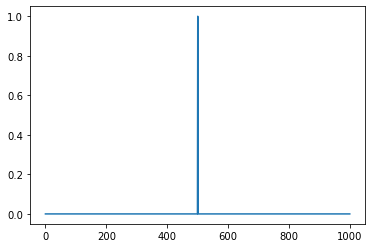

In [3]:
signal = np.zeros(1000)
signal[500] = 1
plt.plot(signal)

In [7]:
class MyTCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 8, kernel_size=81, bias=False),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.layers(x)

In [8]:
tcnmodel = MyTCN()
print(tcnmodel)

MyTCN(
  (layers): Sequential(
    (0): Conv1d(1, 8, kernel_size=(81,), stride=(1,), bias=False)
    (1): ReLU()
  )
)


In [10]:
signal_tensor = torch.tensor(signal, dtype=torch.float32)
print(signal_tensor.shape)

torch.Size([1000])


In [12]:
tcnout = tcnmodel(signal_tensor.reshape(1,1,1000))
print(tcnout.shape)

torch.Size([1, 8, 920])


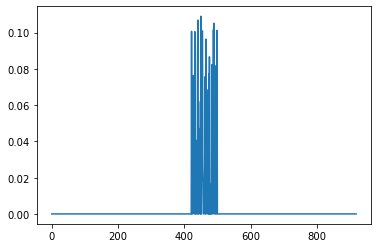

In [13]:
tcnout_np = tcnout.detach()
plt.plot(tcnout_np[0,0])

In [14]:
class MyTCN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 8, kernel_size=81, bias=False, padding = 40),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.layers(x)
    
tcnmodel2 = MyTCN2()
tcnout2 = tcnmodel2(signal_tensor.reshape(1,1,1000)).detach()
print(tcnout2.shape)

torch.Size([1, 8, 1000])


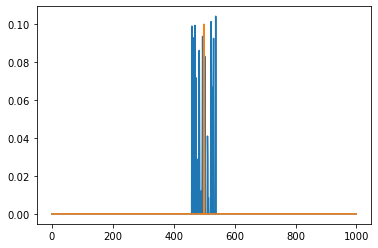

In [15]:
plt.plot(tcnout2[0][0])
plt.plot(signal/10)

In [17]:
tcnmodel2.layers[0].weight.shape

torch.Size([8, 1, 81])

In [20]:
class MyTCN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConstantPad1d(padding=(80,0), value=0),  # padding 0's on the left, this shifts the graph to the right
            # so the graph is past the barrier
            nn.Conv1d(in_channels = 1, out_channels = 8, kernel_size=81, bias=False),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.layers(x)
    
tcnmodel3 = MyTCN3()
tcnout3 = tcnmodel3(signal_tensor.reshape(1,1,1000)).detach()
print(tcnout3.shape)

torch.Size([1, 8, 1000])


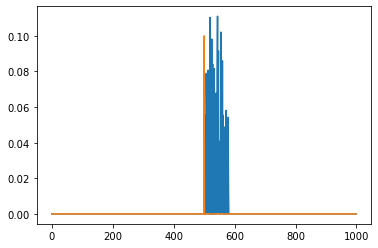

In [19]:
plt.plot(tcnout3[0][0])
plt.plot(signal/10)

# Autoregressive Model

In [21]:
signal = np.sin(np.linspace(0,50,1000))
y = np.sin(np.linspace(0,50,1000) - .8)
y_tensor = torch.tensor(y, dtype = torch.float32)

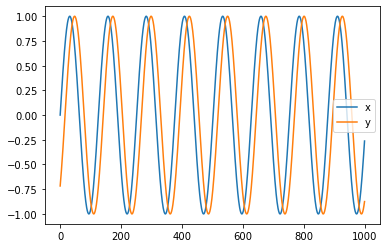

In [22]:
plt.plot(signal,label = "x")
plt.plot(y, label = "y")
plt.legend()

In [23]:
class MyARTCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConstantPad1d(padding = (80,0), value = 0),
            nn.Conv1d(in_channels = 1, out_channels = 8, kernel_size = 81),
            nn.ReLU(),  # (1, 8, 1000),
            nn.Conv1d(in_channels = 8, out_channels = 1, kernel_size = 1)  # we want to reduce the number of outputs,
            # so we make another covolutional layer that accepts the 8 outputs from the first layer, and returns
            # 1 output, just as we wanted
        )
        
    def forward(self, x):
        return self.layers(x)

In [24]:
signal_tensor = torch.tensor(signal, dtype = torch.float32)

In [26]:
armodel = MyARTCN()
optimizer = torch.optim.Adam(armodel.parameters(), lr=.1, weight_decay=.01)
loss_function = nn.MSELoss()

nepoch = 10000
for ii in range(nepoch):
    y_hat = armodel(signal_tensor.reshape((1,1,-1)))
    loss = loss_function(y_hat.squeeze(), y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if not ii% 500:
        print(loss.item())

0.5168320536613464
0.0010739904828369617
0.015673113986849785
0.001247031381353736
0.006526838522404432
0.002123025478795171
0.007503775414079428
0.06849081069231033
0.015750883147120476
0.00614356342703104
0.0021562918554991484
0.0016908827237784863
0.0016814910341054201
0.0016873263521119952
0.0016827845247462392
0.0016854957211762667
0.0019885869696736336
0.0027289169374853373
0.003599988529458642
0.0018116238061338663


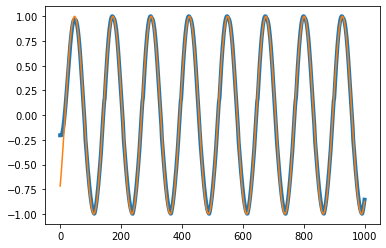

In [27]:
y_hat = armodel(signal_tensor.reshape(1,1,-1))
plt.plot(y_hat.detach().squeeze(), lw=4)
plt.plot(y)

In [28]:
kernels = armodel.layers[1].weight.detach()
print(kernels.shape)

torch.Size([8, 1, 81])


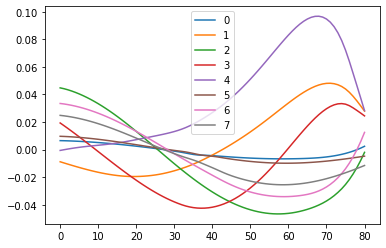

In [30]:
plt.plot(kernels.squeeze().T, label = range(8))
plt.legend()